## Prediction Markets
Prediction markets allow users to trade on the outcome of future events. Users buy "yes" or "no" shares in a specific outcome market, and the shares pay out $1 depending on the outcome of the event. Although interesting these prediction markets can tend to be illiquid and often see large bid-ask spreads

## The overall idea
We will take a look at a very economically significant market: The "US-China trade deal before June?". It is very likely that the US and China reaching an agreement will have a noticeable impact on equity markets. We will, therefore, determine if a lead-lag relationship exists between this market and the SPY500 index, with equity markets assumed to be the leader (as these markets are much more liquid and faster at processing information). To do this, we will employ a VAR model and conduct a Granger causality test, and then build a backtest.

---
## Datacollection.
We collect 30-minute intervals of Polymarket data through their CLOB API. The /prices-history endpoint returns time series data of midpoints at no depth for a given market token ID. We need to collect this data in chunks when we want such high frequencies because of rate limits. The token ID can be found on their website.

In [228]:
import requests
import csv
import sys
import os
import re
import time
from datetime import datetime, timezone


def get_with_backoff(url, params, max_retries=5, backoff_factor=1.0):
    retries = 0

    while retries < max_retries:
        try:
            response = requests.get(url, params=params)
 
            if response.status_code == 200:
                return response
            if response.status_code == 429:
                sleep_time = backoff_factor * (2 ** retries)
                print(f"Rate limited (HTTP 429). Sleeping for {sleep_time} seconds...")
                time.sleep(sleep_time)
                retries += 1
                continue
            response.raise_for_status()
            return response
        except Exception as e:
            sleep_time = backoff_factor * (2 ** retries)
            print(f"Request error: {e}. Retrying in {sleep_time} seconds...")
            time.sleep(sleep_time)
    return response

def fetch_timeseries_chunked(token_id, start_ts, end_ts, fidelity):
    all_history = []
    current_start = start_ts
    CHUNK_SECONDS = (60**2)*24*5 #5 day intervals

    while current_start < end_ts:
        current_end = min(current_start + CHUNK_SECONDS, end_ts)

        url = f"{BASE_URL}/prices-history"
        params = {
            "market": token_id,
            "startTs": int(current_start), 
            "endTs": int(current_end),
            "fidelity": fidelity
        }
        response = get_with_backoff(url, params=params)
        data = response.json()
        chunk_history = data.get("history", [])
        all_history.extend(chunk_history)

        current_start = current_end
    return all_history

BASE_URL = "https://clob.polymarket.com"

start_date = datetime(2025, 1, 1).replace(tzinfo=timezone.utc).timestamp()

end_date = datetime(2025, 5, 7).replace(tzinfo=timezone.utc).timestamp()

fidelity = 30

token_id = '43574888282240197675710510825990137104478048769278676395877833277398528952511'

filename = "US-China-tradedealyes.csv"

history = fetch_timeseries_chunked(token_id, start_date, end_date, fidelity)



with open(filename, mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["timestamp", "price"])
    for point in history:
        writer.writerow([point["t"], point["p"]])
    print(f"saved to {filename}")





saved to US-China-tradedealyes.csv


For the SPY-500 data we will use the Alpha-Vantage API

In [229]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pytz
from dotenv import load_dotenv


load_dotenv()
api_key = os.getenv("api_key")
interval = "30min"
output_file = "SPY_30min_6months_UTC.csv"
symbol = "SPY"
# Calculate the last 6 months (from April 14, 2025)
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 5, 7)
months = []
current_date = start_date
while current_date <= end_date:
    months.append(current_date.strftime("%Y-%m"))
    current_date += relativedelta(months=1)


all_data = []
et_tz = pytz.timezone("America/New_York") 
utc_tz = pytz.timezone("UTC")  


for month in months:
    print(f"Fetching data for {month}...")
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&month={month}&outputsize=full&extended_hours=true&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    
    # Parse time series data
    time_series = data["Time Series (30min)"]
    df = pd.DataFrame.from_dict(time_series, orient="index").astype(float)

    df.index = pd.to_datetime(df.index)

    df.index = df.index.tz_localize(et_tz)

    df.index = df.index.tz_convert(utc_tz)
    
    df.index = df.index.tz_localize(None)
    df.columns = ["Open", "High", "Low", "Close", "Volume"]
    all_data.append(df)
    
    time.sleep(4)

# Combine and sort data
if all_data:
    combined_df = pd.concat(all_data).sort_index()
    combined_df.to_csv(output_file)
    print(f"Data saved to {output_file} with {len(combined_df)} rows.")


Fetching data for 2025-01...
Fetching data for 2025-02...
Fetching data for 2025-03...
Fetching data for 2025-04...
Fetching data for 2025-05...
Data saved to SPY_30min_6months_UTC.csv with 2805 rows.


We will now combine and clean the data and lastly compute log returns.

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("api_key")
api_key

'KIDJ9GC198FOXI24'

In [2]:
import numpy as np
df1 = pd.read_csv("SPY_30min_6months_UTC.csv", index_col="datetime", parse_dates = True)[["Close"]]

df2 = pd.read_csv("US-China-tradedealyes.csv", index_col="timestamp")
df2.index = pd.to_datetime(df2.index, unit="s")
df2 = df2.sort_index()
df2 = df2[~df2.index.duplicated(keep="first")]
df2.index = df2.index.floor("min")

df = df1.join(df2, how='inner')
df.columns = ["SPY Price", "POLY Price"]
df["SPY_log_return"] = np.log(df["SPY Price"] / df["SPY Price"].shift(1))
df["POLY_log_return"] = np.log(df["POLY Price"] / df["POLY Price"].shift(1))
df = df.dropna()

We will do a 50:50 split between training data, and data we will backtest on. Firstly we fit a VAR model, test for heteroskadicity and then compute a granger test. We assume that log returns are stationary.

In [233]:
from statsmodels.tsa.api import VAR


train_model_df = df[["SPY_log_return", "POLY_log_return"]][:len(model_df) // 2]

model = VAR(train_model_df)

lag_order = model.select_order(maxlags=15).aic




whiteness_test = var_model.test_whiteness(nlags=lag_order+1, signif=0.05, adjusted=False)
print(whiteness_test.summary())

results = grangercausalitytests(train_model_df, maxlag=15, verbose=True)

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 2 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         1.207          9.488   0.877  4
----------------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0367  , p=0.8482  , df_denom=317, df_num=1
ssr based chi2 test:   chi2=0.0371  , p=0.8473  , df=1
likelihood ratio test: chi2=0.0371  , p=0.8473  , df=1
parameter F test:         F=0.0367  , p=0.8482  , df_denom=317, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1483  , p=0.8622  , df_denom=314, df_num=2
ssr based chi2 test:   chi2=0.3013  , p=0.8602  , df=2
likelihood ratio test: chi2=0.3012  , p=0.8602  , df=2
parameter F test:         F=0.1483  , p=0.8622  , df_denom=314, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9

Indeed, we find that SPY returns Granger-cause the Polymarket data, and no major heteroskadicity. Thus we will move forward with the backtest.

## Backtest

We will fit a rolling VAR model, and then, if the absolute value of the forecasted returns is above a certain threshold, we will enter a long or short position respectively (you can go short in the prediction market by buying the respective "no" share). We will hold this for a specific period. (All reasonable combination of threshold and holding period gave good results, but these were found to be among the better).

Trades taken: 114
Cumulative strategy PnL: 3.3987442716802048
Sharpe (annualized): 12.577044043767282 0.21973874269774935


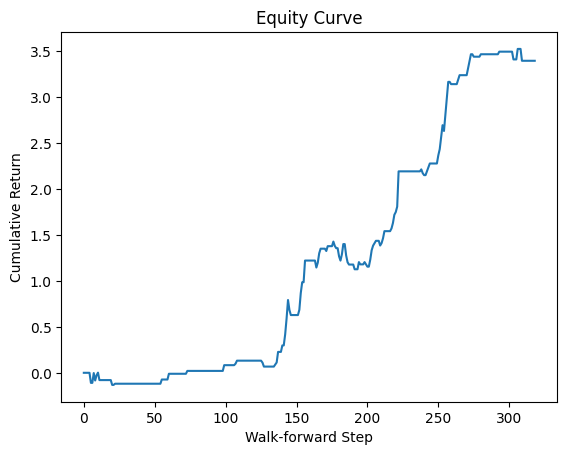

In [8]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


n_train   = len(df)//2 
n_periods = 3      # holding period
threshold = 0.003

signals = []
rets    = []

for t in range(n_train, len(df) - n_periods):
    train = df[["SPY_log_return","POLY_log_return"]].iloc[t-n_train:t]
    sel   = VAR(train).select_order(15).aic
    lag   = int(sel)
    if lag == 0:

        lag = 1

    varf  = VAR(train).fit(lag)
    p     = varf.k_ar
    seed  = train.values[-p:]
    fc    = varf.forecast(seed, steps=n_periods)[:,1]  # POLY forecasts
    

    sig =  1 if fc.mean() >  threshold else \
          -1 if fc.mean() < -threshold else 0

    realized = df["POLY_log_return"].iloc[t:t+n_periods].values
    rets.append(sig * realized.sum())
    signals.append(sig)

rets = np.array(rets)

sr = rets.mean() / rets.std(ddof=0)

sr_ann = sr * np.sqrt(13 * 252)



print("Trades taken:", np.count_nonzero(signals))
print("Cumulative strategy PnL:", rets.sum())
print("Sharpe (annualized):", sr_ann, sr)

plt.plot(np.cumsum(rets))
plt.title("Equity Curve")
plt.xlabel("Walk-forward Step")
plt.ylabel("Cumulative Return")
plt.show()


# Conclusions
We find an incredible 12,6 annualized Sharpe ratio. This is, of course, highly unrealistic. The major problem arises from the fact that the data from Polymarket is based on midpoints with no depth, and as such, trading at these values is in no way feasible. Bid-ask spreads can often be over 3 cents, which might make this strategy totally unprofitable. Furthermore, the best bid-asks often only carry a few dollars of volume.

Overall, this backtest shows potential for a strategy, given further cost modeling and better trade execution. 

In [6]:
import matplotlib.pyplot as plt
s = 0
my_list = []
for n in range(1,20):
    s += (4*(-1)**n)/(2*n+1)
    my_list.append([n, s])
print(my_list)


[[1, -1.3333333333333333], [2, -0.5333333333333332], [3, -1.1047619047619046], [4, -0.6603174603174602], [5, -1.023953823953824], [6, -0.7162615162615162], [7, -0.9829281829281828], [8, -0.747634065281124], [9, -0.9581603810705976], [10, -0.7676841905944072], [11, -0.941597234072668], [12, -0.781597234072668], [13, -0.9297453822208162], [14, -0.7918143477380575], [15, -0.9208466058025736], [16, -0.7996344845904524], [17, -0.9139201988761667], [18, -0.8058120907680586], [19, -0.9083761933321611]]
